In [1]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
batch_size = 16
num_batches = 1000

In [3]:
# Define a feedforward NN representing the sensory-motor system

input_vis = tf.placeholder(shape=[batch_size, 2], dtype=tf.float32, name = 'input_vis')
input_aud = tf.placeholder(shape=[batch_size, 2], dtype=tf.float32, name = 'input_aud')
input_total = tf.concat([input_vis, input_aud], axis = -1)

num_hidden_sensorymotor = 10
hidden_sensorymotor = tf.contrib.layers.fully_connected(input_total, num_hidden_sensorymotor, activation_fn = tf.nn.relu)
num_out_sensorymotor = 2
out_sensorymotor = tf.contrib.layers.fully_connected(hidden_sensorymotor, num_out_sensorymotor, activation_fn = tf.nn.relu)

In [4]:
# Just train the sensory-motor system to ignore audition
run_sensorymotor_test = False

if run_sensorymotor_test:
    loss = tf.reduce_mean(tf.norm(out_sensorymotor-input_vis))
    learning_rate = 0.01
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op=optimizer.minimize(loss)
    
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    
    num_inputs = batch_size*num_batches
    
    in_vis_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_inputs)] 
    in_vis_list = np.reshape(in_vis_list_unshaped, [num_batches,batch_size,2])
    
    in_aud_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_inputs)]
    in_aud_list = np.reshape(in_aud_list_unshaped, [num_batches,batch_size,2])

    losses = []
    for i in range(num_batches):
        in_vis_list_batch = in_vis_list[i]
        in_aud_list_batch = in_aud_list[i]
        l, it, os, _ =  sess.run([loss, input_total, out_sensorymotor, train_op], feed_dict = {input_vis:in_vis_list_batch, input_aud:in_aud_list_batch})
        losses.append(l)
        
    plt.figure()
    plt.plot(losses)
    plt.title("Loss function versus number of batches")
    plt.show()

In [5]:
# Define a feedforward NN representing the sensory-motor system with an ancillary rule label input

input_vis = tf.placeholder(shape=[batch_size, 2], dtype=tf.float32, name = 'input_vis')
input_aud = tf.placeholder(shape=[batch_size, 2], dtype=tf.float32, name = 'input_aud')
input_cue = tf.placeholder(shape=[batch_size, 1], dtype=tf.float32, name = 'input_cue')
input_total = tf.concat([input_vis, input_aud, input_cue], axis = -1)

num_hidden_sensorymotor = 10
hidden_sensorymotor = tf.contrib.layers.fully_connected(input_total, num_hidden_sensorymotor, activation_fn = tf.nn.relu)
num_out_sensorymotor = 2
out_sensorymotor = tf.contrib.layers.fully_connected(hidden_sensorymotor, num_out_sensorymotor, activation_fn = tf.nn.relu)

In [6]:
# Train the sensory-motor system to follow the given rule
run_sensorymotor_rule_test = False

if run_sensorymotor_rule_test:    
    
    num_inputs = batch_size*num_batches
    
    in_vis_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_inputs)] 
    in_vis_list = np.reshape(in_vis_list_unshaped, [num_batches,batch_size,2])
    
    in_aud_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_inputs)]
    in_aud_list = np.reshape(in_aud_list_unshaped, [num_batches,batch_size,2])
    
    cue_list_unshaped = [[np.random.rand()] for k in range(num_inputs)]
    in_cue_list = np.reshape(cue_list_unshaped, [num_batches,batch_size,1])
                
    learning_rate = 0.01
    optimizer = tf.train.AdamOptimizer(learning_rate)
    
    sess = tf.Session()
    
    losses = []
    for i in range(num_batches):
        in_vis_list_batch = in_vis_list[i]
        in_aud_list_batch = in_aud_list[i]
        in_cue_list_batch = in_cue_list[i]
        
        loss = 0
        for j in range(batch_size):
            if in_cue_list_batch[j] > 0.5:
                loss += tf.norm(tf.gather(out_sensorymotor-input_vis, [j]))
            else:
                loss += tf.norm(tf.gather(out_sensorymotor-input_aud, [j]))
        
        train_op=optimizer.minimize(loss)
        
        sess.run(tf.initialize_all_variables())
        l, it, os, _ =  sess.run([loss, input_total, out_sensorymotor, train_op], feed_dict = {input_vis:in_vis_list_batch, input_aud:in_aud_list_batch, input_cue:in_cue_list_batch})
        losses.append(l)
        print l
        
    plt.figure()
    plt.plot(losses)
    plt.title("Loss function versus number of batches")
    plt.show()

In [7]:
# Now we will create a mapping from cues to rules
# The rule associated with each cue will change with time and a RNN will have to learn and remember the recent mapping
# while not hanging onto it too long as the mapping changes

# Define an RNN representing the PFC

if False: # Do we run this block

    num_units_PFC = 5

    PFC_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_PFC)
    PFC_state_previous = PFC_cell.zero_state(batch_size, tf.float32) # Initial state of PFC

    # This does one cycle of the RNN
    def PFC_step(input_data, network_state):
        with tf.variable_scope("PFC", reuse=False):
            return PFC_cell(inputs = input_data, state = network_state) 

    # Cue inputs

    num_timesteps = 5
    cue_timeseries = tf.placeholder(shape=[batch_size, num_timesteps, 1], dtype=tf.float32, name = 'cues_timeseries')

    for t in range(num_timesteps):

        current_cue = cue_timeseries[:,t]

        PFC_state = PFC_step(input_data = current_cue, network_state = PFC_state_previous)
        # The output from the PFC into the sensorymotor system will be what we were previously calling the cue variable
        # We'll now call it the rule
        PFC_output = tf.contrib.layers.fully_connected(PFC_state[0], 1, activation_fn = tf.nn.relu)

        PFC_state_previous = PFC_state[1]

    sess = tf.Session()

    ct = np.reshape([np.random.rand() for k in range(num_timesteps * batch_size * num_batches)], [num_batches, batch_size, num_timesteps, 1])

    sess.run(tf.initialize_all_variables())

    for b in range(num_batches):

        ct_in = ct[b, :, :]

        o = sess.run([PFC_output], feed_dict = {cue_timeseries:ct_in})

        print o

Loss: 30.337461



timestep 0
out [[ 0.45719886  0.49725309]
 [ 0.54027086  0.05616803]
 [ 0.78132749  0.41998348]
 [ 0.28797203  0.20161538]
 [ 0.49700922  0.42345381]
 [ 0.11584595  0.64713508]
 [ 0.40304333  0.33437955]
 [ 0.33134043  0.54227477]
 [ 0.46643996  0.39061856]
 [ 0.74599737  0.15143912]
 [ 0.4009662   0.57256395]
 [ 0.1411619   0.15160388]
 [ 0.53633052  0.59321696]
 [ 0.19374557  0.42294234]
 [ 0.67364705  0.15481785]
 [ 0.57772851  0.00488169]] 
vis in [[ 0.37185347  0.71853742]
 [ 0.53973028  0.00735999]
 [ 0.88337413  0.81285716]
 [ 0.55818585  0.06547872]
 [ 0.72390674  0.66367936]
 [ 0.03968921  0.91704169]
 [ 0.50738132  0.42772615]
 [ 0.06714081  0.72939077]
 [ 0.33205646  0.20465546]
 [ 0.83442935  0.44912635]
 [ 0.77631461  0.45224893]
 [ 0.0353363   0.07140771]
 [ 0.43645014  0.56579395]
 [ 0.34937572  0.82405574]
 [ 0.82451224  0.08318734]
 [ 0.72575876  0.03220653]] 
aud in [[ 0.73044017  0.51665823]
 [ 0.70300913  0.2602054 ]
 [ 0.85788734  0.30635225]
 [ 

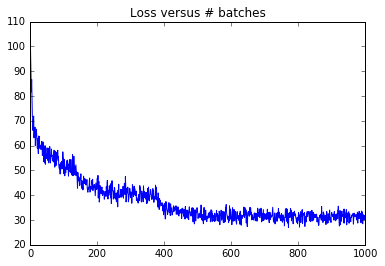

In [8]:
# Now we will create a mapping from cues to rules
# The rule associated with each cue will change with time and a RNN will have to learn and remember the recent mapping
# while not hanging onto it too long as the mapping changes

# Define an RNN representing the PFC

num_units_PFC = 20

PFC_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_PFC)
PFC_state_previous = PFC_cell.zero_state(batch_size, tf.float32) # Initial state of PFC

# This does one cycle of the RNN
def PFC_step(input_data, network_state):
    with tf.variable_scope("PFC", reuse=False):
        return PFC_cell(inputs = input_data, state = network_state) 
    
# Cue inputs

num_timesteps = 10
cue_timeseries = tf.placeholder(shape=[batch_size, num_timesteps, 1], dtype=tf.float32, name = 'cues_timeseries')

input_vis = tf.placeholder(shape=[batch_size, num_timesteps, 2], dtype=tf.float32, name = 'input_vis')
input_aud = tf.placeholder(shape=[batch_size, num_timesteps, 2], dtype=tf.float32, name = 'input_aud')

def rvis():
    return 1.0
def raud():
    return 2.0
def rnull():
    return 0.0

def cue_to_rule_mapping_function(t, integer_input): # Define a changing mapping from cues to rules
    
    if t % 10 < 10: # Always true here but we'll make this change later -- we can use this to set up time-dependent cue-to-rule mappings
        r1 = tf.cond(tf.equal(integer_input, tf.constant(0, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
    
        r2 = tf.cond(tf.equal(integer_input, tf.constant(1, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
        
        r3 = tf.cond(tf.equal(integer_input, tf.constant(2, dtype = tf.float32)), true_fn = raud, false_fn = rnull)
        
        r4 = tf.cond(tf.equal(integer_input, tf.constant(3, dtype = tf.float32)), true_fn = raud, false_fn = rnull)
    else: # We can use this to set up time-dependent cue-to-rule mappings
        r1 = tf.cond(tf.equal(integer_input, tf.constant(0, dtype = tf.float32)), true_fn = raud, false_fn = rnull)
    
        r2 = tf.cond(tf.equal(integer_input, tf.constant(1, dtype = tf.float32)), true_fn = raud, false_fn = rnull)
        
        r3 = tf.cond(tf.equal(integer_input, tf.constant(2, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
        
        r4 = tf.cond(tf.equal(integer_input, tf.constant(3, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
        
    return tf.reduce_max([r1,r2,r3,r4])

loss = 0

outs = []

rules_chosen = []

for t in range(num_timesteps):

    current_cue = cue_timeseries[:,t]

    PFC_state = PFC_step(input_data = current_cue, network_state = PFC_state_previous)
    # The output from the PFC into the sensorymotor system will be what we were previously calling the cue variable
    # We'll now call it the rule
    PFC_output = tf.contrib.layers.fully_connected(PFC_state[0], 1, activation_fn = tf.nn.relu)
    
    input_cue_to_sm_sys = PFC_output
    input_total = tf.concat([input_vis[:,t], input_aud[:,t], input_cue_to_sm_sys], axis = -1)
    
    num_hidden_sensorymotor = 20
    hidden_sensorymotor = tf.contrib.layers.fully_connected(input_total, num_hidden_sensorymotor, activation_fn = tf.nn.relu)
    num_out_sensorymotor = 2
    out_sensorymotor = tf.contrib.layers.fully_connected(hidden_sensorymotor, num_out_sensorymotor, activation_fn = tf.nn.relu)
    
    PFC_state_previous = PFC_state[1]
    
    rul_chose = []
    for e in range(batch_size):
        cc = current_cue[e][0]
        cue_to_rule_mapping_function_output = cue_to_rule_mapping_function(t, cc)
        if t>=0: # Always true here but we'll make this change later -- we can use this to set up time-dependent loss functions, e.g., only look at late times
            loss_contrib = tf.cond(tf.equal(cue_to_rule_mapping_function_output, tf.constant(1, dtype = tf.float32)), true_fn = lambda: tf.norm(input_vis[e,t] - out_sensorymotor[e]),  false_fn = lambda: tf.norm(input_aud[e,t] - out_sensorymotor[e]))
            loss += loss_contrib
        rul_chose.append(cue_to_rule_mapping_function_output)
    rules_chosen.append(rul_chose)

    outs.append(out_sensorymotor)
        
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op=optimizer.minimize(loss)

sess = tf.Session()

# Random cue
ct = np.reshape([np.random.randint(0,4) for k in range(num_timesteps * batch_size * num_batches)], [num_batches, batch_size, num_timesteps, 1])
    
in_vis_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_timesteps * batch_size * num_batches)] 
in_vis_list = np.reshape(in_vis_list_unshaped, [num_batches,batch_size,num_timesteps, 2])

in_aud_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_timesteps * batch_size * num_batches)]
in_aud_list = np.reshape(in_aud_list_unshaped, [num_batches,batch_size,num_timesteps, 2])

sess.run(tf.initialize_all_variables())

losses = []

for b in range(num_batches): # Just testing
        
    ct_in = ct[b, :, :]

    in_v = in_vis_list[b, :, :]

    in_a = in_aud_list[b, :, :]

    os, l, rc, _ = sess.run([outs, loss, rules_chosen, train_op], feed_dict = {cue_timeseries:ct_in, input_vis: in_v, input_aud:in_a})
    # The outputs here are just for the last batch...
    losses.append(l)
    
print "Loss: %f" %l
print "\n\n"
for q in range(num_timesteps):
    print "timestep %i" % q
    print "out", os[:][q], "\n", "vis in", in_v[:,q],"\n", "aud in", in_a[:, q],"\n", "rule chosen", rc[:][q],"\n", "correct rule", [sess.run(cue_to_rule_mapping_function(q, float(ct_in[e,q]))) for e in range(batch_size)]  
    print "\n"
        
plt.figure()
plt.plot(losses)
plt.title("Loss versus # batches")
plt.show()